In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as linalg
import torch_geometric.utils as utils
from torch.distributions import Bernoulli
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import GCNConv
torch.set_printoptions(precision=5,sci_mode=False, linewidth=200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
print('Using device:', device)
loss_fn = nn.BCEWithLogitsLoss()

Using device: cpu


## Data models and learners

In [2]:
class CSBM:
    def __init__(self, n_points, n_features, gamma, p=1., q=0.):
        self.n_points = n_points
        self.n_features = n_features
        self.gamma = gamma # prop to ratio of dist b/w means to the std dev.
        self.std = 1./gamma
        self.p = p
        self.q = q
        # Fix a randomly generated mean on the unit sphere.
        self.u = torch.rand(n_features)
        self.u /= linalg.norm(self.u)
        
    # The XGMM synthetic data model definition.
    def gmm(self, equipart, no_var):
        u = self.u
        X = torch.zeros((self.n_points, self.n_features))
        y = torch.zeros(self.n_points, dtype=torch.long)
        stdvec = self.std*torch.ones_like(u)
        if equipart:
            y[self.n_points//2:] = 1
            for i in range(self.n_points//2):
                X[i] = -u if no_var else torch.normal(-u, stdvec)
            
            for i in range(self.n_points//2):
                X[i+self.n_points//2] = u if no_var else torch.normal(u, stdvec)
        else:
            # Decide class based on a Bernoulli.
            eps = Bernoulli(torch.tensor([0.5]))
            for i in range(self.n_points):
                y[i] = eps.sample()
                mean = (2*y[i] - 1)*u
                X[i] = mean if no_var else torch.normal(mean, stdvec)
        
        return Data(x=X, y=y, edge_index=None)

    def generate_data(self, tr_split=0.05, equipart=False, no_var=False):
        data = self.gmm(equipart, no_var)
        # The inbuilt function stochastic_blockmodel_graph does not support
        # random permutations of the nodes, hence, design it manually.
        probs = torch.tensor([[self.p, self.q], [self.q, self.p]], dtype=torch.float)
        
        # Use with_replacement=True to include self-loops.
        row, col = torch.combinations(torch.arange(self.n_points), r=2, with_replacement=False).t()
        mask = torch.bernoulli(probs[data.y[row], data.y[col]]).to(torch.bool)
        edges = torch.stack([row[mask], col[mask]], dim=0)
        edges = utils.to_undirected(edges, num_nodes=self.n_points)
        data.edge_index = edges
        
        # Split the data into train and test.
        c0 = torch.where(data.y == 0)[0]
        c1 = torch.where(data.y == 1)[0]
        tr_nodes = int(tr_split*data.num_nodes)
        tr_mask = torch.zeros_like(data.y).bool()
        tr_mask[c0[:tr_nodes]] = True
        tr_mask[c1[:tr_nodes]] = True
        data.train_mask = tr_mask
        data.test_mask = ~tr_mask
        data.adj_t = torch.sparse_coo_tensor(
            data.edge_index,
            torch.ones(data.num_edges),
            (data.num_nodes, data.num_nodes)).coalesce()
        return data

# Compute prediction accuracy.
def accuracy(out, target):
    probs = torch.sigmoid(out)
    probs[probs>.5] = 1
    probs[probs<=.5] = 0
    corrects = (probs == target)
    acc = corrects.sum().float() / target.size(0)
    return acc

# Graph signal.
def signal_g(a, b):
    return np.abs(a - b) / (a + b)

In [3]:
# MLP with ReLU activations and sigmoidal output.
class MLP(torch.nn.Module):
    def __init__(self, n_layers, n_features, bias=True, channels=None):
        super().__init__()
        self.name = 'mlp'
        self.n_layers = n_layers
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Identity()
        self.dropout = nn.Dropout(0.5)
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(nn.Sequential(
                nn.Linear(channels[0][i], channels[1][i], bias=bias),
                self.activations[i]
            ))
        self.module_list = nn.ModuleList(self.module_list)
    
    def forward(self, x):
        for module in self.module_list:
            x = module(x)
        return torch.squeeze(x, dim=1)

# GCN with ReLU activations and sigmoidal output.
class GCN(torch.nn.Module):
    def __init__(self, n_layers, n_features, bias=True, channels=None):
        super().__init__()
        self.name = 'gcn'
        self.n_layers = n_layers
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Identity()
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(GCNConv(channels[0][i], channels[1][i], bias=bias))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        for i, module in enumerate(self.module_list):
            x = module(x, edge_index)
            x = self.activations[i](x)
        return torch.squeeze(x, dim=1)

# ClipGNN architecture.
class ClipGNN(MessagePassing):
    def __init__(self, n_layers, n_hops, n_features, bias=True, channels=None):
        super().__init__()
        self.name = 'clipgnn'
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        self.mlp = MLP(n_layers, n_features, bias=bias, channels=channels)
        self.n_hops = n_hops
        self.clips = nn.Parameter(torch.Tensor(n_hops, channels[-1][-1]))
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.uniform_(self.clips, -1., 1.)

    def forward(self, data):
        eye_indices = torch.vstack((torch.arange(data.num_nodes), torch.arange(data.num_nodes))).to(device)
        ones = torch.ones(data.num_nodes).to(device)
        A0 = torch.sparse_coo_tensor(
            eye_indices,
            ones,
            (data.num_nodes, data.num_nodes)).coalesce()

        A1 = torch.sparse_coo_tensor(
            data.edge_index,
            torch.ones(data.num_edges).to(device),
            (data.num_nodes, data.num_nodes)).coalesce()
        
        A2 = self.constructA2(data.num_nodes, A0, A1, data.adj_t)
        
        representation = self.mlp(data.x)
        for hop in range(1, self.n_hops+1):
            if hop == 1:
                out = self.propagate(A1.indices(), x=data.x, size=None)
            elif hop >= 2:
                out = self.propagate(A2.indices(), x=data.x, size=None)
                A0 = A1
                A1 = A2
                A2 = self.constructA2(data.num_nodes, A0, A1, data.adj_t)

            out = self.mlp(out)
            out = torch.where(out < -self.clips[hop-1], -self.clips[hop-1], out)
            out = torch.where(out > self.clips[hop-1], self.clips[hop-1], out)
            representation += out
        
        return representation

    def constructA2(self, n, A0, A1, adj_t):
        A2 = torch.sparse.mm(A1, adj_t)
        A2 = torch.sparse_coo_tensor(
            A2._indices(),
            torch.ones_like(A2._indices()[0], dtype=torch.float),
            (n, n))
        
        A2 -= A0
        indices = A2._indices()
        values = A2._values()
        indices = indices[:,values > 0]
        values = values[values > 0]
        A2 = torch.sparse_coo_tensor(indices, values, (n, n)).coalesce()
        return A2

In [4]:
# Plot everything.
def plot(xaxis, yaxes, title, xlabel, ylabel, legend_labels, fname):
    linestyles = ['solid', 'solid', 'solid']
    markers = ['s', '.', '.']
    ms = [8, 12, 12]
    fig = plt.figure(figsize=(10,5), facecolor=[1,1,1])
    # plt.title(title)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.grid()
    for (i, yaxis) in enumerate(yaxes):
        plt.plot(xaxis, yaxis, linewidth=4, linestyle=linestyles[i], marker=markers[i], label=legend_labels[i], markersize=ms[i])
    plt.legend(fontsize=30)
    plt.show()
    fig.savefig('figures/' + fname + '.pdf', dpi=400, bbox_inches='tight')

def train_model(model, data, loss_fn, lr=0.01, epochs=250, eps=1e-5, logs=None):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1.0e-3)
    epoch = 0
    print_freq = 20
    prev_loss = 0
    wspace = 8*' '
    while epoch < epochs:
        optimizer.zero_grad()
        out = model(data.x) if model.name == 'mlp' else model(data)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask].float())
        loss.backward()
        optimizer.step()
        if logs is not None and epoch % print_freq == 0:
            print(logs + ' Loss: ' + str(round(loss.item(), 5)) + wspace, end='\r')
        if np.abs(prev_loss - loss.item()) <= eps and loss.item() < eps:
            break
        epoch += 1
        prev_loss = loss.item()

In [5]:
def experiment(n, d, p, q, l):
    gammas = torch.linspace(0.1, 3.5, 30)
    channels = [
        [[d], [1]],
        [[d, 1], [1, 1]]
    ]

    mlp = MLP(n_layers=1, n_features=d, bias=False, channels=channels[l-1]).to(device)
    gcn = GCN(n_layers=l, n_features=d, bias=False, channels=channels[l-1]).to(device)
    clipGNN = ClipGNN(n_layers=1, n_hops=l, n_features=d, bias=False, channels=channels[l-1]).to(device)

    accs_mlp = torch.zeros(len(gammas))
    accs_gcn = torch.zeros(len(gammas))
    accs_bayes = torch.zeros(len(gammas))
    for i, gamma in enumerate(gammas):
        csbm = CSBM(n, d, gamma, p=p, q=q)
        data = csbm.generate_data(equipart=True, no_var=False).to(device)

        # Train the models.
        train_model(mlp, data, loss_fn, logs='Training MLP,')
        train_model(gcn, data, loss_fn, logs='Training GCN,')
        train_model(clipGNN, data, loss_fn, logs='Training ClipGNN,')
        
        # Test the models.
        mlp.eval()
        gcn.eval()
        clipGNN.eval()
        out_mlp = mlp(data.x)
        out_gcn = gcn(data)
        out_clipGNN = clipGNN(data)
        tmsk = data.test_mask
        accs_mlp[i] = accuracy(out_mlp[tmsk], data.y[tmsk])
        accs_gcn[i] = accuracy(out_gcn[tmsk], data.y[tmsk])
        accs_bayes[i] = accuracy(out_clipGNN[tmsk], data.y[tmsk])
    return gammas, [accs_bayes, accs_mlp, accs_gcn]

# Perform experiment and plot.
def run_sim(n, d, p, q, l):
    xaxis, yaxes = experiment(n, d, p, q, l)
    title = r'For graph signal $\Gamma$=' + str(round(signal_g(p, q), 2))
    xlabel = r'GMM signal $\gamma$'
    ylabel = 'Accuracy'
    fname = f'acc_vs_fSNR_{str(p*n//2)}_{str(q*n//2)}_l={str(l)}'
    plot(xaxis, yaxes, title, xlabel, ylabel, ['Bayes Optimal', 'MLP', 'GCN'], fname)

/var/folders/w3/c7ng27q12xzdp16_sx_wdvt00000gn/T/ipykernel_22081/3138473704.py:116: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402629672/work/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  A2 = torch.sparse.mm(A1, adj_t)


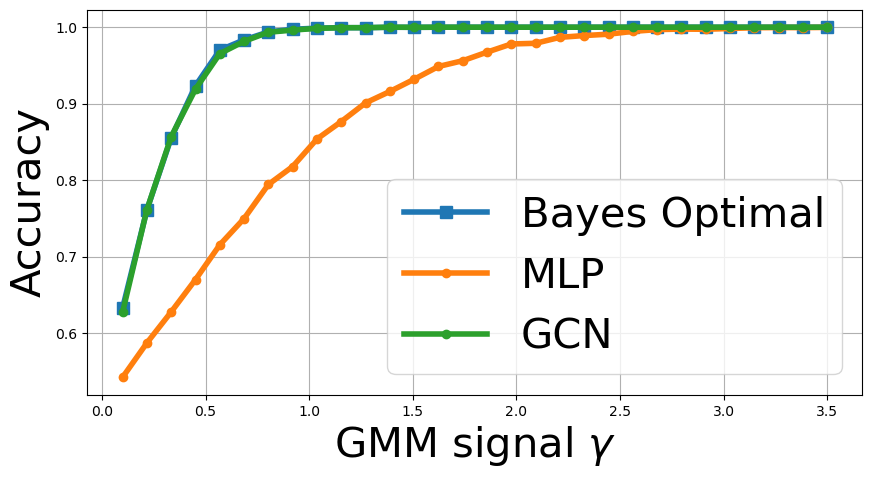

In [6]:
n, d = 10000, 4
p, q = 0.002, 0.0
run_sim(n, d, p, q, l=1)

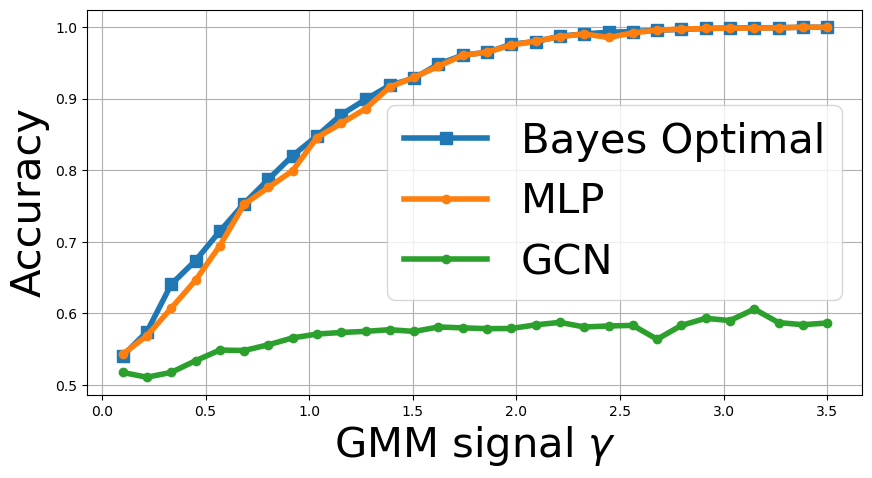

In [7]:
n, d = 10000, 4
p, q = 0.002, 0.002
run_sim(n, d, p, q, l=1)

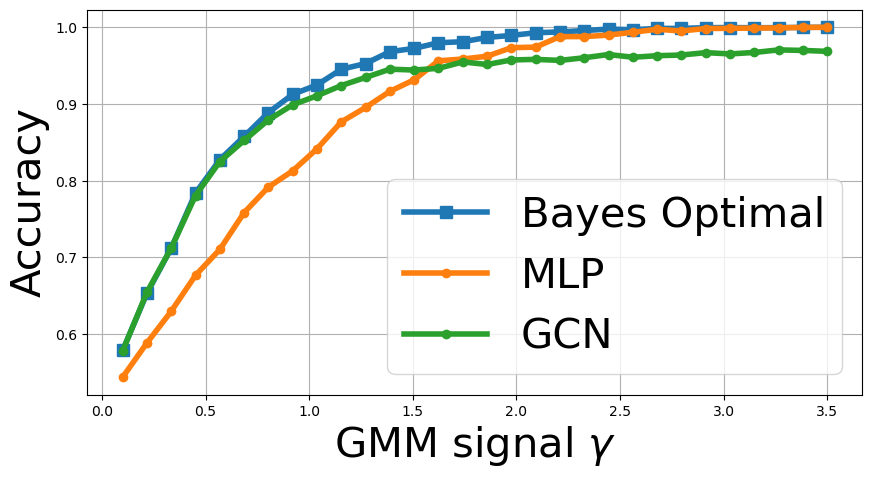

In [8]:
n, d = 10000, 4
p, q = 0.002, 0.0008
l = 2
run_sim(n, d, p, q, l=1)

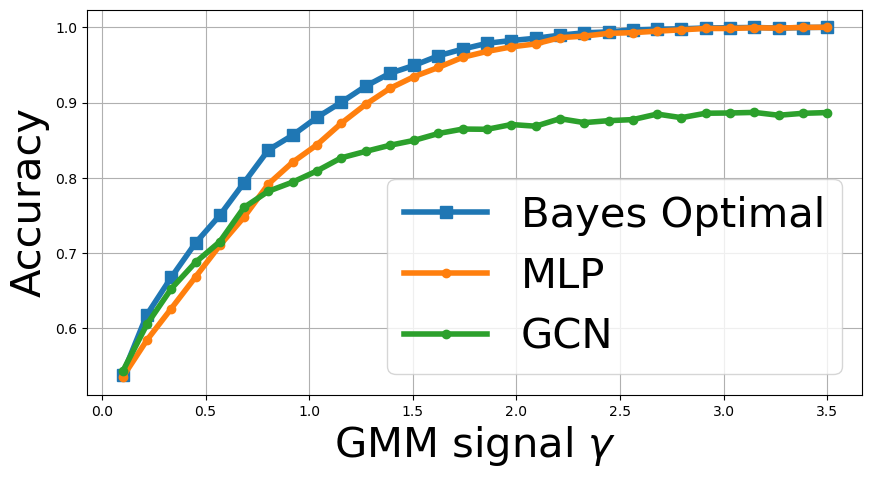

In [9]:
n, d = 10000, 4
p, q = 0.002, 0.0012
run_sim(n, d, p, q, l=1)